# Regression Analysis with Regularization: Understanding important predictors of diabetes and obesity prevalence and make predictions

In [67]:
from sklearn.linear_model import Lasso
import numpy as np
import pandas as pd

read in necessary datasets

In [68]:
url='https://raw.githubusercontent.com/cathyxinxyz/Capstone_Project_1/master/Datasets/combined.csv'
df=pd.read_csv(url,index_col='FIPS',encoding="ISO-8859-1")

In [69]:
#read in variable information and build variable information dictionary with variable names as key
url='https://raw.githubusercontent.com/cathyxinxyz/Capstone_Project_1/master/Datasets/Food_atlas/Var_name_info.csv'
var_info_df=pd.read_csv(url,encoding="ISO-8859-1", index_col='variable')

In [70]:
#read in variable information and build variable information dictionary with variable names as key
url='https://raw.githubusercontent.com/cathyxinxyz/Capstone_Project_1/master/Datasets/rural_urban_category.csv'
rucc_info_df=pd.read_csv(url,encoding="ISO-8859-1")

In [71]:
from sklearn import preprocessing
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

df=df[df.columns.difference(['State','County'])]

In [72]:
df['RUCC_2013']=df['RUCC_2013'].astype(str)

In [73]:
df = pd.get_dummies(df, drop_first=True)

In [74]:
df.shape

(3141, 62)

In [75]:
rucc_info_df.info

<bound method DataFrame.info of    RUCC_2013                                         categories
0          2  Metro - Counties in metro areas of 250,000 to ...
1          3  Metro - Counties in metro areas of fewer than ...
2          6  Nonmetro - Urban population of 2,500 to 19,999...
3          1  Metro - Counties in metro areas of 1 million p...
4          9  Nonmetro - Completely rural or less than 2,500...
5          7  Nonmetro - Urban population of 2,500 to 19,999...
6          8  Nonmetro - Completely rural or less than 2,500...
7          4  Nonmetro - Urban population of 20,000 or more,...
8          5  Nonmetro - Urban population of 20,000 or more,...>

In [76]:
rucc_info_df['RUCC_2013']=rucc_info_df['RUCC_2013'].apply(lambda x:'RUCC_2013_'+str(x))

In [77]:
rucc_info_df=rucc_info_df.set_index('RUCC_2013')

# missing value imputation

In [78]:
#pipeline with missing values imputation and regression
# Import the Imputer module
from sklearn.preprocessing import Imputer, scale
# Setup the Imputation transformer: imp
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp_data=imp.fit_transform(df.values)
imp_data.shape
data=pd.DataFrame(imp_data, index=df.index, columns=df.columns)

# Elasticnet regression: Train, Cross validation, and Test

In [79]:
#define functions to return variable meaning given variable names
def Feature_names(c):
    if c in var_info_df.index:
        return var_info_df.loc[c]['meaning']
    elif c in rucc_info_df.index:
        return rucc_info_df.loc[c]['categories']
    elif c=='frac_uninsured':
        return 'fraction of uninsured population <=65 years'
    else:
        return c

In [80]:
predictors=data.drop(['prevalence of diabetes', 'prevalence of obesity'], axis=1)
X=predictors.values
y_db=data['prevalence of diabetes'].values
y_ob=data['prevalence of obesity'].values

Tune model when diabetes prevalence is the outcome variable

In [81]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_db, test_size=0.25, random_state=42)

In [82]:
from sklearn.linear_model import ElasticNetCV
regr_db = ElasticNetCV(cv=5, random_state=42, 
                    l1_ratio=[0.1,0.3,0.4, 0.5,0.55, 0.6, 0.65, 0.75, 0.8, 0.9,1], max_iter=5000, n_alphas=5000, normalize=True)
regr_db.fit(X_train, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.75, 0.8, 0.9, 1],
       max_iter=5000, n_alphas=5000, n_jobs=1, normalize=True,
       positive=False, precompute='auto', random_state=42,
       selection='cyclic', tol=0.0001, verbose=0)

In [83]:
print(regr_db.alpha_) 
print (regr_db.l1_ratio_)
print(regr_db.intercept_) 
r2 = regr_db.score(X_test,y_test)
print (r2)

0.000243779750192
1.0
0.173423747069
0.762701521201


plot coefficients when diabetes prevalence is the outcome variable

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

#construct coefficient dataframe
coef_db = pd.DataFrame(np.round_(regr_db.coef_, decimals=3), columns = ["coefficients"])
coef_db['variables']=predictors.columns
coef_db['features']=coef_db['variables'].apply(Feature_names)        
# remove the zero coefficients
coef_db = coef_db[coef_db['coefficients'] != 0]
# sort the values from high to low
coef_db = coef_db.sort_values(by = 'coefficients', ascending = False)
coef_db['outcome variable']=['diabetes' for n in range(len(coef_db.index))]

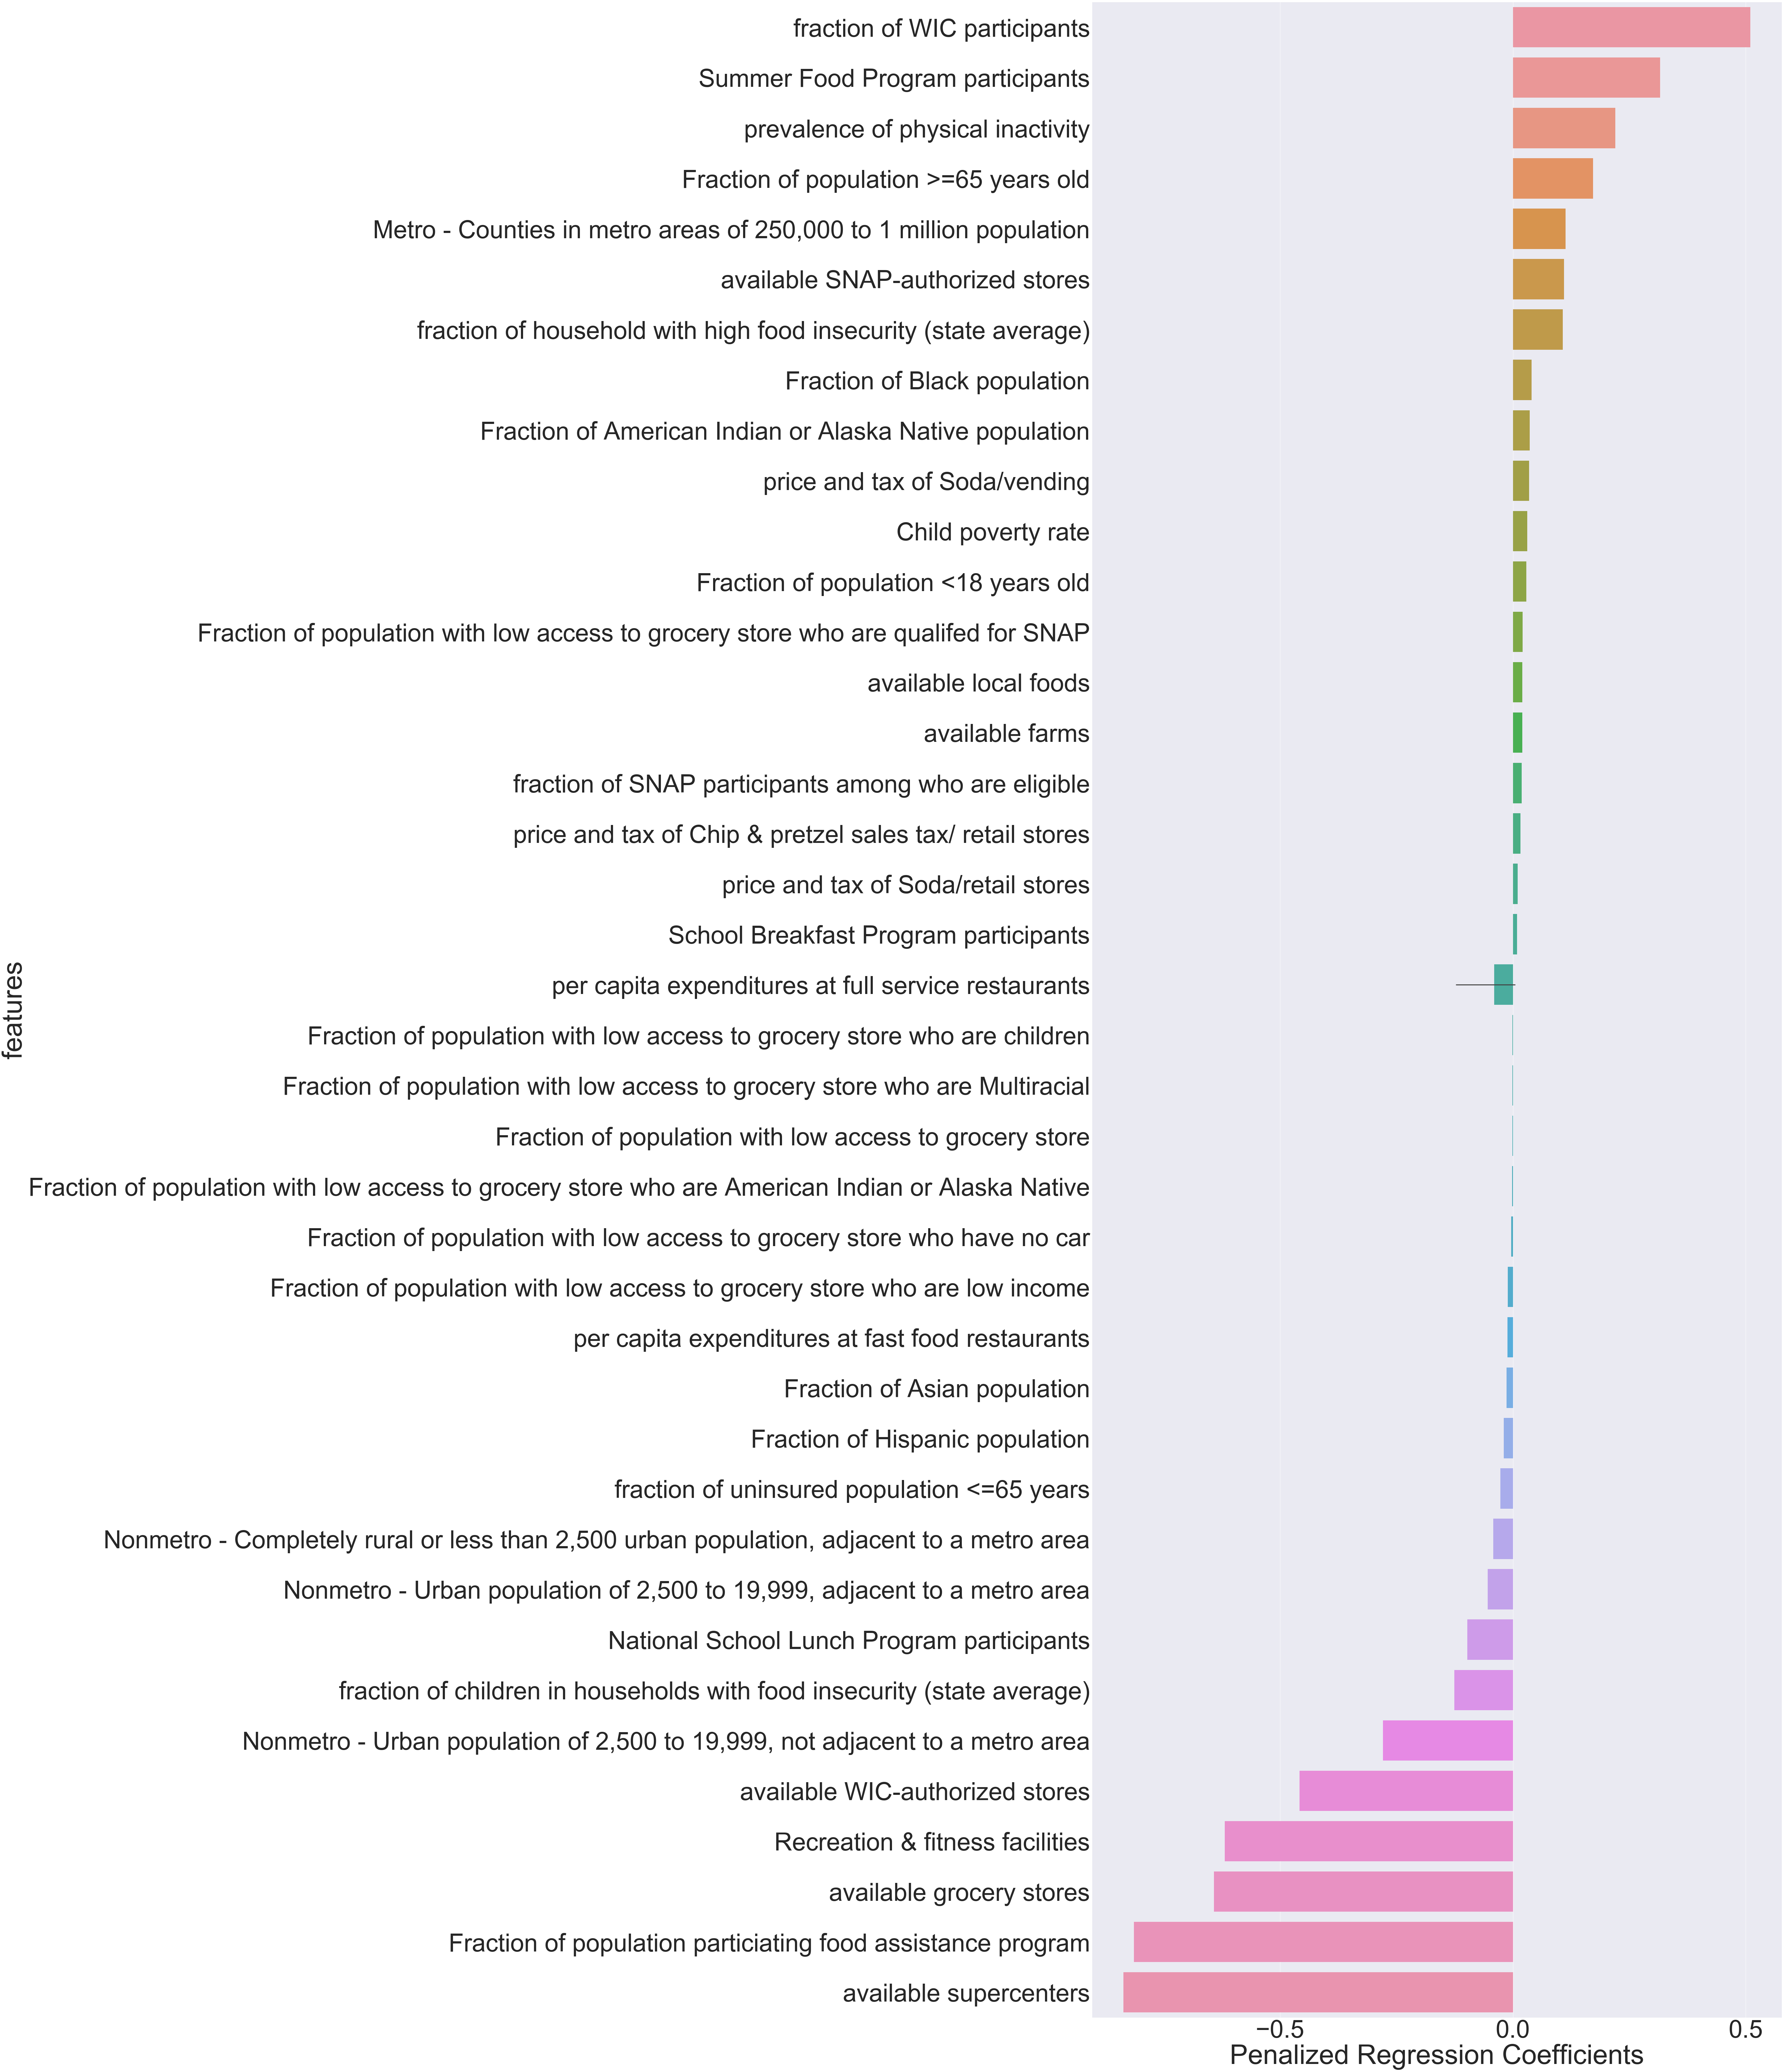

In [92]:
# plot the sorted dataframe
plt.figure(figsize=(40,120))
ax = sns.barplot(x = 'coefficients', y= coef_db['features'] , data=coef_db)
ax.set(xlabel='Penalized Regression Coefficients')
sns.set(font_scale = 30)
plt.show()

Tune the model when outcome variable is obesity prevalence

In [86]:
from sklearn.linear_model import ElasticNetCV
X_train, X_test, y_train, y_test = train_test_split(X, y_ob, test_size=0.25, random_state=42)
#alphas=[0, 0.0001, 0.001, .1, 1, 10, 100]
regr_ob = ElasticNetCV(cv=5, random_state=42, 
                    l1_ratio=[0.1,0.3,0.4, 0.5,0.55, 0.6, 0.65, 0.75, 0.8, 0.9,1], max_iter=5000, n_alphas=5000, normalize=True)
regr_ob.fit(X_train, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.75, 0.8, 0.9, 1],
       max_iter=5000, n_alphas=5000, n_jobs=1, normalize=True,
       positive=False, precompute='auto', random_state=42,
       selection='cyclic', tol=0.0001, verbose=0)

In [87]:
print(regr_ob.alpha_) 
print (regr_ob.l1_ratio_)
print(regr_ob.intercept_) 
r2 = regr_ob.score(X_test,y_test)
print (r2)

0.00192520422494
1.0
27.3625270887
0.688537216965


plot coefficients when obesity prevalence is the outcome variable

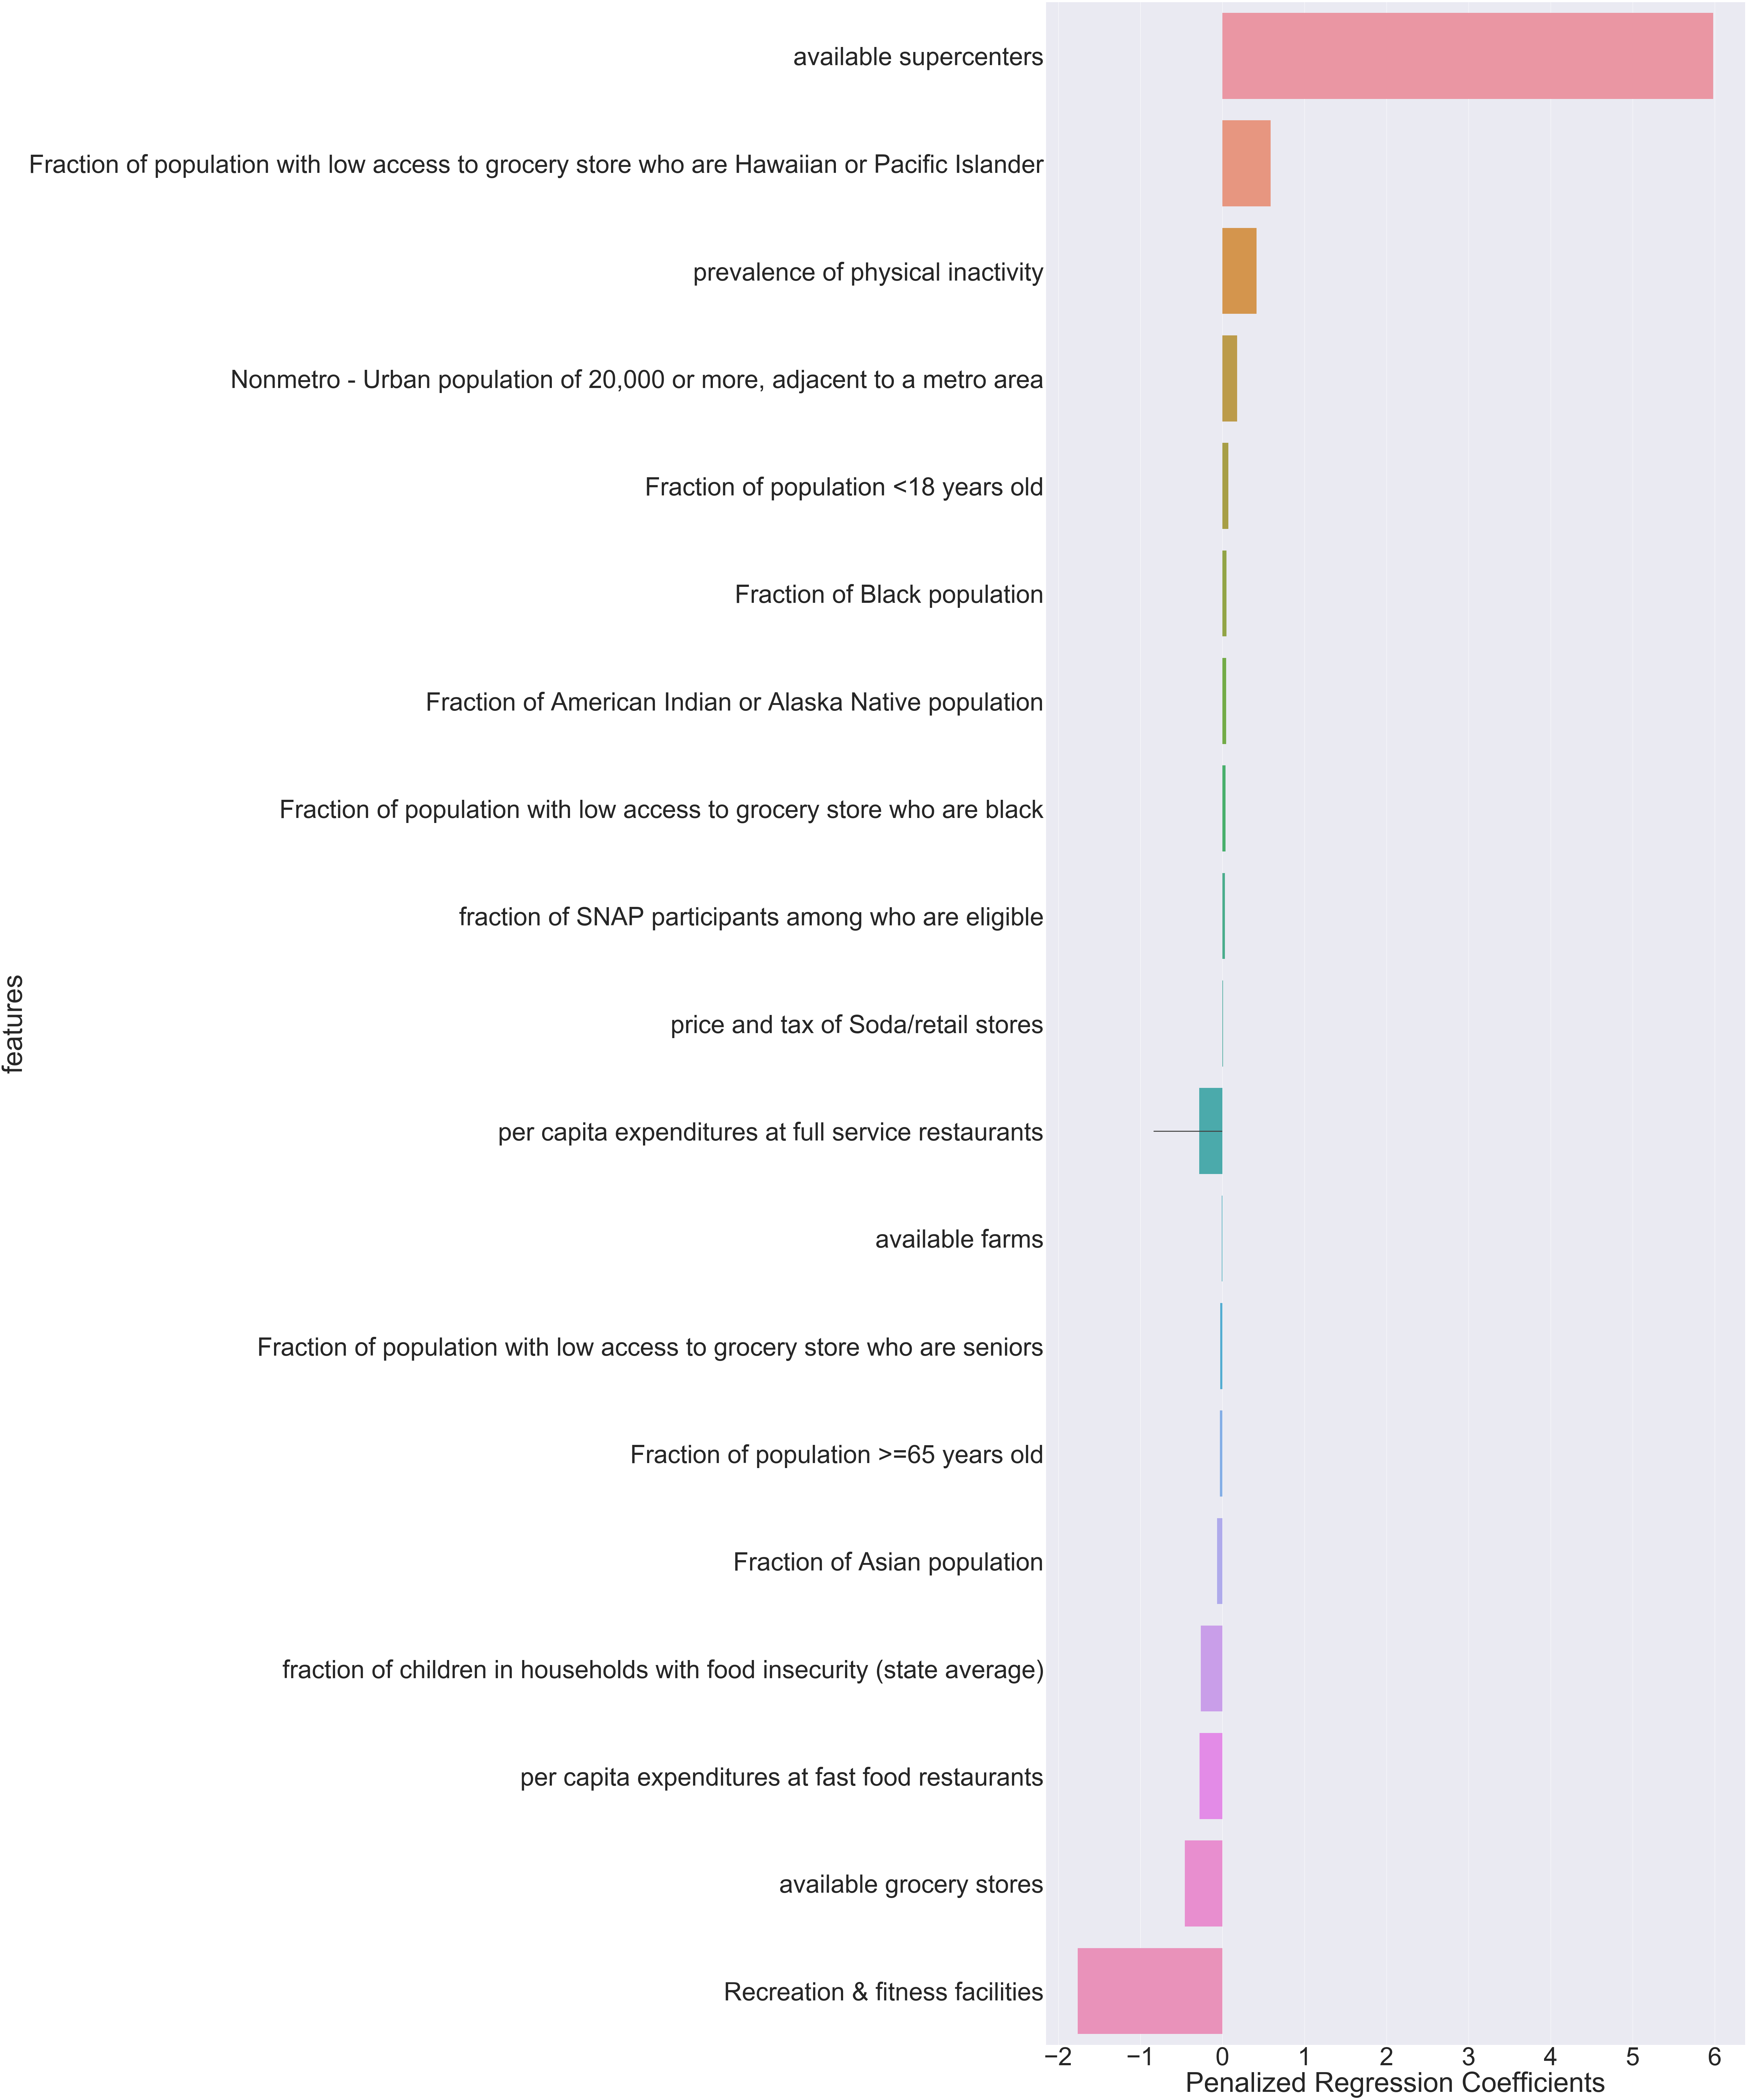

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

coef_ob = pd.DataFrame(np.round_(regr_ob.coef_, decimals=3), columns = ["coefficients"])

coef_ob['variables']=predictors.columns
coef_ob['features']=coef_ob['variables'].apply(Feature_names)        
# remove the zero coefficients
coef_ob = coef_ob[coef_ob['coefficients'] != 0]
# sort the values from high to low
coef_ob = coef_ob.sort_values(by = 'coefficients', ascending = False)

coef_ob['outcome variable']=['obesity' for n in range(len(coef_ob.index))]

# plot the sorted dataframe
plt.figure(figsize=(40,120))
ax = sns.barplot(x = 'coefficients', y= coef_ob['features'] , data=coef_ob)
ax.set(xlabel='Penalized Regression Coefficients')
sns.set(font_scale = 8)
plt.show()

In [89]:
#combine coefficients for diabetes and coefficients for obesity for comparison purpose
coefs=pd.concat([coef_db,coef_ob], axis=0)

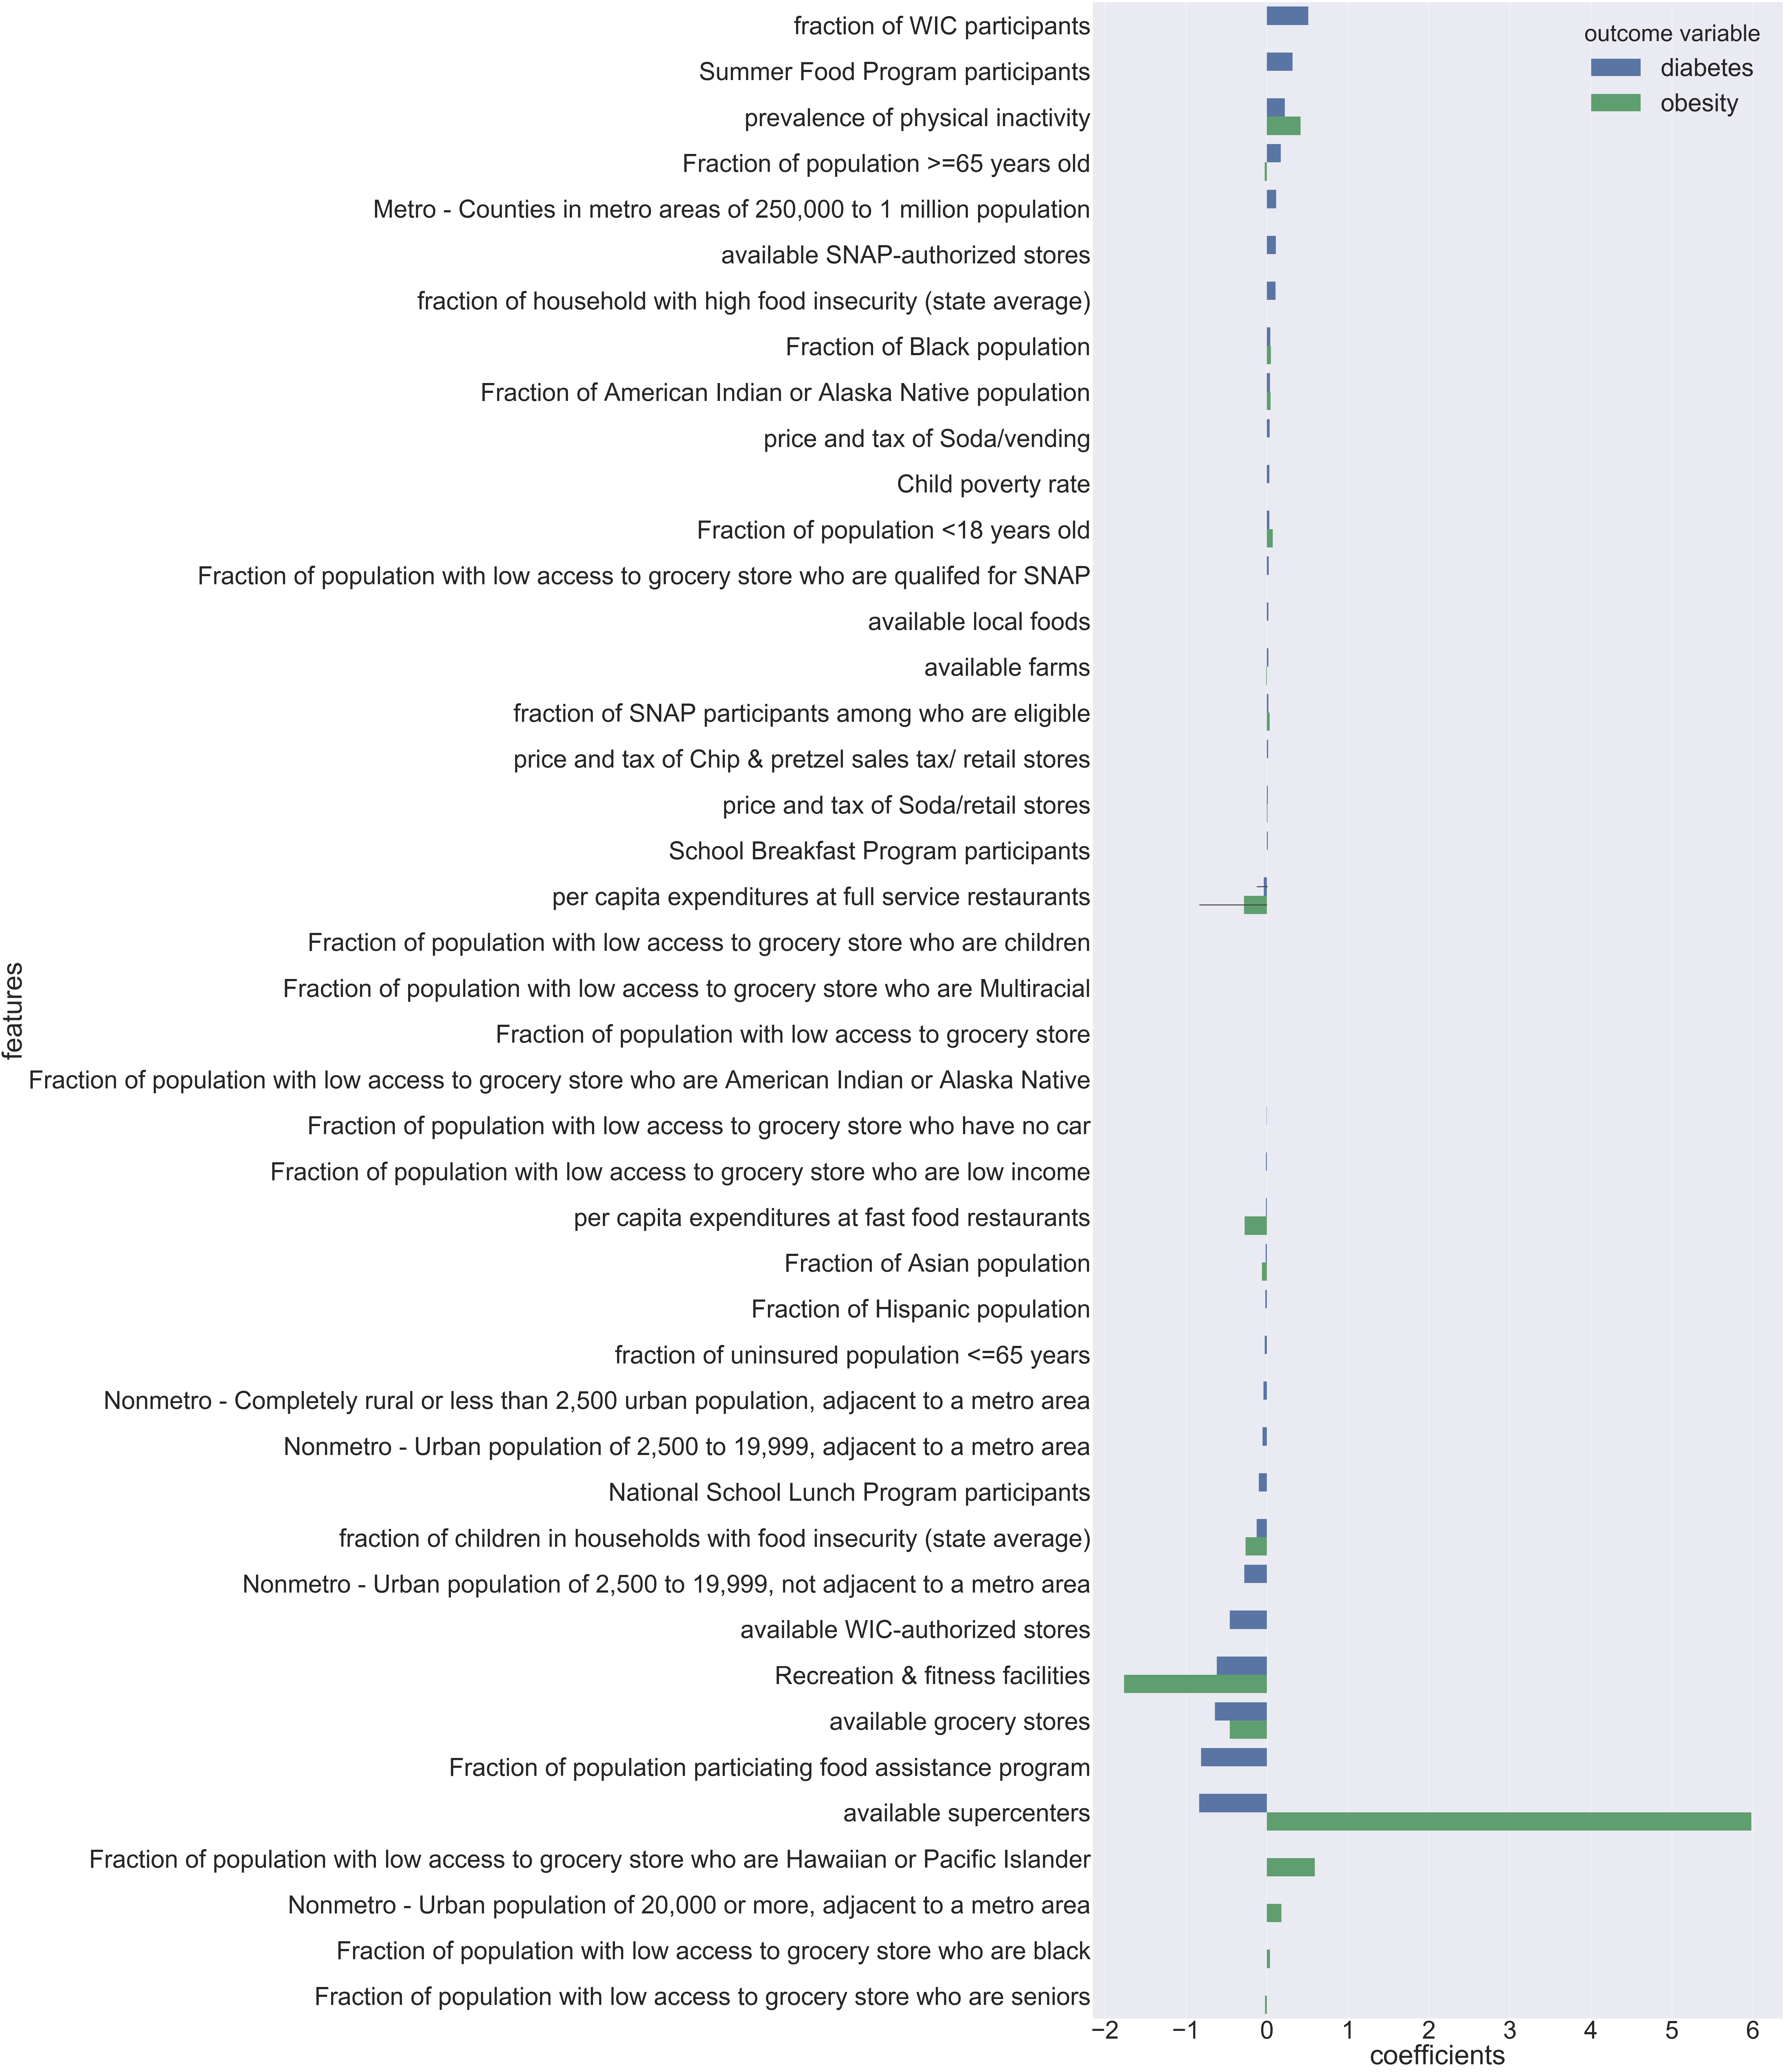

In [91]:
plt.figure(figsize=(40,120))
ax = sns.barplot(x = 'coefficients', y= 'features' , data=coefs, hue='outcome variable')
sns.set(font_scale = 8)
plt.show()

In [ ]:
#compare chosen features
select_features=["Fraction of population >=65 years old", 
"fraction of WIC participants",
"prevalence of physical inactivity",
"Fraction of Hawaiian or Pacific Islander",
"available supercenters",
"Recreation & fitness facilities",
"Fraction of uninsured population <=65 years",
"Fraction of population <18 years old"]

plt.figure(figsize=(40,40))
ax = sns.barplot(x = 'coefficients', y= 'features' , data=coefs[coefs['features'].isin(select_features)], hue='outcome variable')
sns.set(font_scale = 8)
plt.show()

# Predict prevalence of diabetes and obesity given changed variables

In [ ]:
def Predict(df, var, change, model):
    df[var]=df[var].apply(lambda x:x+change)
    X_pred=df.values
    predicted=model.predict(X_pred)
    return predicted

In [ ]:
predictors=data.drop(['prevalence of diabetes', 'prevalence of obesity'], axis=1)
df=predictors
var='prevalence of physical inactivity'
change=-5
model=regr_db
db_pred=Predict(df, var, change, model)
db_pred=pd.DataFrame(db_pred)
db_pred.index=data.index
db_pred.to_csv('C:/Users/cathy/Capstone_project_1/Datasets/Dataset_created_during_analysis/predicted_db_drop_phy_by_5pc.csv')

In [ ]:
predictors=data.drop(['prevalence of diabetes', 'prevalence of obesity'], axis=1)
df=predictors
for c in predictors.columns:
    if c in var_info_df.index:
        if var_info_df.loc[c]['meaning']=='available grocery stores':
            var=c
change=5
model=regr_db
db_pred=Predict(df, var, change, model)
db_pred=pd.DataFrame(db_pred)
db_pred.index=data.index
db_pred.to_csv('C:/Users/cathy/Capstone_project_1/Datasets/Dataset_created_during_analysis/predicted_db_increase_grocery_by_5pc.csv')

In [ ]:
predictors=data.drop(['prevalence of diabetes', 'prevalence of obesity'], axis=1)
df=predictors
for c in predictors.columns:
    if c in var_info_df.index:
        if var_info_df.loc[c]['meaning']=='Recreation & fitness facilities':
            var=c
change=5
model=regr_ob
ob_pred=Predict(df, var, change, model)
ob_pred=pd.DataFrame(db_pred)
ob_pred.index=data.index
ob_pred.to_csv('C:/Users/cathy/Capstone_project_1/Datasets/Dataset_created_during_analysis/predicted_ob_increase_recreation_by_5pc.csv')

In [ ]:
predictors=data.drop(['prevalence of diabetes', 'prevalence of obesity'], axis=1)
df=predictors
for c in predictors.columns:
    if c in var_info_df.index:
        if var_info_df.loc[c]['meaning']=='available local foods':
            var=c
change=5
model=regr_ob
ob_pred=Predict(df, var, change, model)
ob_pred=pd.DataFrame(ob_pred)
ob_pred.index=data.index
ob_pred.to_csv('C:/Users/cathy/Capstone_project_1/Datasets/Dataset_created_during_analysis/predicted_ob_increase_localfood_by_5pc.csv')